# Intrinsic Gaussian CAR model
CARモデルのPyMC3実装を参考にして, Intrinsic Gaussian CARモデルを実装する.   
https://docs.pymc.io/notebooks/PyMC3_tips_and_heuristic.html

参考文献:
Exact sparse CAR models in Stan. Max Joseph. August 20, 2016  
https://mc-stan.org/users/documentation/case-studies/mbjoseph-CARStan.html

de oliveira, Victor. (2012). Bayesian analysis of conditional autoregressive models. Annals of the Institute of Statistical Mathematics. 64. 107-133. 10.1007/s10463-010-0298-1.   
https://www.ism.ac.jp/editsec/aism/pdf/10463_2010_Article_298.pdf

Intrinsic Gaussian CAR model:
\begin{align}
y_i \mid \{y_j : j \neq i\} \sim \text{Normal}(\alpha\Sigma_{j\neq i} b_{ij}y_j, \tau_i^{-1}).
\end{align}
ここで, $y_i$ は観測データ, $B=(b_{ij})$ は scaled adjacency matrix.
$m_i=i$の近傍場所数とし、$D=(\text{diag}(m_i)), \ W=(w_{ij})$ を $w_{ii}=0$, $i$ と $j$が隣接していたら $w_{ij}=1$, 隣接していなければ $w_{ij}=0$を満たすような adjacency matrix とすると, $B=D^{-1}W$ である.

同時分布は
\begin{align}
y \sim \text{Normal}(0, [\tau (D - \alpha W)]^{-1}).
\end{align}
で与えられる.

In [1]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
import ForneyLab.dot2svg
using LinearAlgebra
@everywhere using Mamba
using Plots
using Statistics
using StatsBase

## Lip cancer risk data
まずは同様にScotlandのLip cancer risk dataを準備する. 元データは  
Kemp I. (1989) Scottish Cancer Incidence Atlas 1985. In: Boyle P., Muir C.S., Grundmann E. (eds) Cancer Mapping. Recent Results in Cancer Research, vol 114. Springer, Berlin, Heidelberg

Lip cancer rates $O_i$ は AFF (population employed in agriculture, fishing, or forestry) $a_i$, 場所差パラメーター $y_i$, expected rates $E$ を用いて
\begin{align}
O_i &\sim \text{Poisson}(\lambda_i), \\
\log \lambda_i & = \beta_0 + \beta_1 a_i + y_i + \log E_i
\end{align}
と表される. 

In [3]:
# observed
observed =
    [ 9, 39, 11, 9, 15,  8, 26,  7,  6, 20, 
     13,  5,  3, 8, 17,  9,  2,  7,  9,  7, 
     16, 31, 11, 7, 19, 15,  7, 10, 16, 11,
      5,  3,  7, 8, 11,  9, 11,  8,  6,  4,
     10,  8,  2, 6, 19,  3,  2,  3, 28,  6,
      1,  1,  1, 1,  0,  0]
# expected rates
expected =
    [ 1.4,  8.7, 3.0,  2.5,  4.3,  2.4,  8.1, 2.3,  2.0,  6.6,
      4.4,  1.8, 1.1,  3.3,  7.8,  4.6,  1.1, 4.2,  5.5,  4.4,
     10.5, 22.7, 8.8,  5.6, 15.5, 12.5,  6.0, 9.0, 14.4, 10.2,
      4.8,  2.9, 7.0,  8.5, 12.3, 10.1, 12.7, 9.4,  7.2,  5.3,
     18.8, 15.8, 4.3, 14.6, 50.7,  8.2,  5.6, 9.3, 88.7, 19.6, 
      3.4,  3.6, 5.7,  7.0,  4.2,  1.8]
#  AFF (population employed in agriculture, fishing, or forestry)
aff = 
   [16, 16, 10, 24, 10, 24, 10, 7,  7, 16,
     7, 16, 10, 24,  7, 16, 10, 7,  7, 10,
     7, 16, 10,  7,  1,  1,  7, 7, 10, 10,
     7, 24, 10,  7,  7,  0, 10, 1, 16,  0,
     1, 16, 16,  0,  1,  7,  1, 1,  0,  1,
     1, 0, 1, 1, 16, 10] ./ 10;
#  Spatial adjacency information
adj = 
    [[5, 9, 11,19],
    [7, 10],
    [6, 12],
    [18,20,28],
    [1, 11,12,13,19],
    [3, 8],
    [2, 10,13,16,17],
    [6],
    [1, 11,17,19,23,29],
    [2, 7, 16,22],
    [1, 5, 9, 12],
    [3, 5, 11],
    [5, 7, 17,19],
    [31,32,35],
    [25,29,50],
    [7, 10,17,21,22,29],
    [7, 9, 13,16,19,29],
    [4, 20, 28,33,55,56],
    [1, 5, 9, 13,17],
    [4, 18,55],
    [16,29,50],
    [10,16],
    [9, 29,34,36,37,39],
    [27,30,31,44,47,48,55,56],
    [15,26,29],
    [25,29,42,43],
    [24,31,32,55],
    [4, 18,33,45],
    [9, 15,16,17,21,23,25,26,34,43,50],
    [24,38,42,44,45,56],
    [14,24,27,32,35,46,47],
    [14,27,31,35],
    [18,28,45,56],
    [23,29,39,40,42,43,51,52,54],
    [14,31,32,37,46],
    [23,37,39,41],
    [23,35,36,41,46],
    [30,42,44,49,51,54],
    [23,34,36,40,41],
    [34,39,41,49,52],
    [36,37,39,40,46,49,53],
    [26,30,34,38,43,51],
    [26,29,34,42],
    [24,30,38,48,49],
    [28,30,33,56],
    [31,35,37,41,47,53],
    [24,31,46,48,49,53],
    [24,44,47,49],
    [38,40,41,44,47,48,52,53,54],
    [15,21,29],
    [34,38,42,54],
    [34,40,49,54],
    [41,46,47,49],
    [34,38,49,51,52],
    [18,20,24,27,56],
    [18,24,30,33,45,55]];

In [4]:
N = length(observed)

56

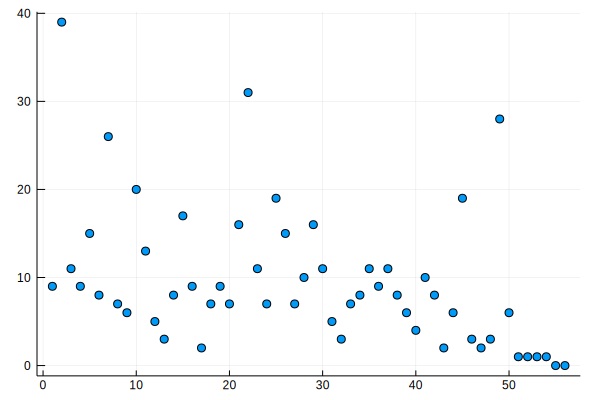

In [5]:
scatter(1:N, observed, label = "")

### 空間統計モデルの定義

In [6]:
car_model = Model(
    beta0 = Stochastic(() -> Normal()),
    beta1 = Stochastic(() -> Normal()),
    
    tau = Stochastic(() -> Distributions.Gamma(2.0, 0.5)),
    alpha = Stochastic(() -> Uniform()),
    phi = Stochastic(1,
        (tau, alpha, N, D, W) -> MvNormalCanon(zeros(N), tau * (D - alpha * W)),
    ),
    
    mu = Logical(1, 
        (beta0, beta1, zscore_aff, phi, log_offset) -> exp.(beta0 .+ beta1 .* zscore_aff .+ phi .+ log_offset)
    ),
    
    y = Stochastic(1,
        (mu, N) -> UnivariateDistribution[Poisson(mu[i]) for i in 1:N],
        false
    )
)

Object of type "Model"
-------------------------------------------------------------------------------
alpha:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta0:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
mu:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
phi:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
tau:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta1:
A monitored node of type "ScalarStoch

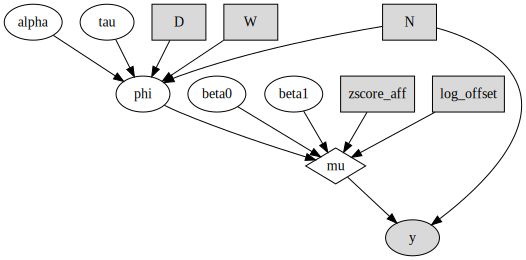

In [7]:
display("image/svg+xml", dot2svg(graph2dot(car_model)))

## データの準備

$D=(\text{diag}(m_i)):$

In [8]:
D = Diagonal(length.(adj))

56×56 Diagonal{Int64,Array{Int64,1}}:
 4  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  2  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  2  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  3  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  5  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  2  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  5  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  6  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  4  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  4  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  3  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

Spatial adjacency informationを行列に展開する

In [9]:
W = zeros(Int64, N, N)
for (i, a) in enumerate(adj)
   W[i, a] .= 1 
end
W

56×56 Array{Int64,2}:
 0  0  0  0  1  0  0  0  1  0  1  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  1  1  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  1  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  1  0  0  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  1  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  1  0  0  0  1  0  0  1  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  1  0  0  0  0  0  1  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  1  0  0  0  0  0  0    

In [10]:
log_offset = log.(expected)
zscore_aff = zscore(aff)
car_data = Dict{Symbol, Any}(
    :log_offset => log_offset,
    :zscore_aff => zscore_aff,
    :N => N,
    :D => D,
    :W => W,
    :y => observed
)

Dict{Symbol,Any} with 6 entries:
  :N          => 56
  :y          => [9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1…
  :D          => [4 0 … 0 0; 0 2 … 0 0; … ; 0 0 … 5 0; 0 0 … 0 6]
  :W          => [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 1 0]
  :log_offset => [0.336472, 2.16332, 1.09861, 0.916291, 1.45862, 0.875469, 2.09…
  :zscore_aff => [1.07564, 1.07564, 0.196285, 2.24812, 0.196285, 2.24812, 0.196…

初期値の設定

In [11]:
car_inits = [
    Dict{Symbol, Any}(
        :beta0 => 0.0,
        :beta1 => 0.0,
        :tau => 0.5,
        :alpha => 0.5,
        :phi => rand(Normal(), N),
        :mu => observed,
        :y => observed,
    ) for i in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:alpha=>0.5,:beta0=>0.0,:mu=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:y=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:phi=>[0.0495617, -0.452531, 1.57176, 0.786097, -0.896208, -0.0792143, -1.33948, -0.0939281, 1.68212, 1.31561  …  0.584479, 0.447758, -0.213671, 1.5029, 0.362099, 0.443369, -0.84163, -0.471128, 1.24105, -0.322812],:tau=>0.5,:beta1=>0.0)
 Dict(:alpha=>0.5,:beta0=>0.0,:mu=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:y=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:phi=>[0.131963, -1.63093, 0.578943, -2.1077, -0.475654, -1.24739, 0.17318, -0.564407, 0.622307, -0.789932  …  -0.668674, 0.0975086, 0.106365, 1.32301, -2.11384, -1.07749, 1.33019, 0.555193, 1.48177, -1.24811],:tau=>0.5,:beta1=>0.0)    
 Dict(:alpha=>0.5,:beta0=>0.0,:mu=>[9, 39, 11, 9, 15, 8, 26, 7, 6, 20  …  2, 3, 28, 6, 1, 1, 1, 1, 0, 0],:y=>[9, 39, 11, 9, 15, 8, 

## サンプリング

In [12]:
car_scheme = [
    AMWG([:beta0, :beta1, :phi], 1.0), 
    Slice(:alpha, 1.0),
    Slice(:tau, 10.0),
]

3-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:beta0, :beta1, :phi]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Multivariate}}"
Sampling Block Nodes:
Symbol[:alpha]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 1.0), Const(##287#289{Bool,Float64}(false, 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                                                    

In [13]:
setsamplers!(car_model, car_scheme)
car_sim = mcmc(car_model, car_data, car_inits, 21000, burnin = 1000, thin = 10, chains = 3)

MCMC Simulation of 21000 Iterations x 3 Chains...

      From worker 4:	Chain 2:   0% [4:03:22 of 4:03:29 remaining]
      From worker 2:	Chain 1:   0% [4:02:14 of 4:02:21 remaining]
      From worker 3:	Chain 3:   0% [3:58:50 of 3:58:57 remaining]
      From worker 2:	Chain 1:  10% [0:02:52 of 0:03:11 remaining]
      From worker 4:	Chain 2:  10% [0:02:55 of 0:03:15 remaining]
      From worker 3:	Chain 3:  10% [0:02:54 of 0:03:13 remaining]
      From worker 2:	Chain 1:  20% [0:02:02 of 0:02:32 remaining]
      From worker 3:	Chain 3:  20% [0:02:01 of 0:02:32 remaining]
      From worker 4:	Chain 2:  20% [0:02:05 of 0:02:36 remaining]
      From worker 2:	Chain 1:  30% [0:01:37 of 0:02:18 remaining]
      From worker 3:	Chain 3:  30% [0:01:37 of 0:02:18 remaining]
      From worker 4:	Chain 2:  30% [0:01:39 of 0:02:22 remaining]
      From worker 2:	Chain 1:  40% [0:01:19 of 0:02:12 remaining]
      From worker 3:	Chain 3:  40% [0:01:19 of 0:02:11 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

[0.33094 1.46703 … 3.00364 1.30891; 0.33094 1.91188 … 3.37455 1.45741; … ; 0.247464 1.42399 … 3.23905 1.433; 0.215707 1.05484 … 3.24568 0.826445]

[0.299406 0.87525 … 2.46176 1.22608; 0.259757 1.31149 … 1.50415 0.331976; … ; 0.314044 2.17268 … 2.02256 1.62447; 0.334104 1.68496 … 5.35047 1.59214]

[0.241514 1.40915 … 7.16718 0.479625; 0.241514 1.13513 … 2.48423 1.25604; … ; 0.256256 0.937077 … 2.6287 1.34367; 0.193823 1.91152 … 3.84367 0.599082]

## サンプリング結果を確認する

In [14]:
describe(car_sim)

Iterations = 1010:21000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 2000

Empirical Posterior Estimates:
            Mean         SD        Naive SE       MCSE         ESS    
  beta1  0.245238569 0.09108135 0.00117585517 0.0026454404 1185.394598
    tau  1.476873536 0.44673406 0.00576731190 0.0066700184 2000.000000
  beta0  0.043326583 0.35918476 0.00463705528 0.0360161964   99.458088
  alpha  0.956477802 0.04813539 0.00062142518 0.0014394530 1118.237262
 phi[1]  1.220848359 0.46547435 0.00600924803 0.0356328804  170.643461
 phi[2]  1.153356535 0.40725650 0.00525765884 0.0366274531  123.629642
 phi[3]  1.061323496 0.46024793 0.00594177526 0.0360205675  163.261052
 phi[4]  0.466775676 0.49065432 0.00633432007 0.0372030892  173.937511
 phi[5]  1.042437088 0.42347260 0.00546700777 0.0362695585  136.322046
 phi[6]  0.670866569 0.49528707 0.00639412862 0.0365129821  184.000659
 phi[7]  0.981333973 0.40277546 0.00519980877 0.0361152790  124.378137
 phi[8]  0.986530430 0.508095

phi[22] -0.756186173 -0.235219938  0.020876197  0.2994446260  0.89907719
phi[23] -0.781867908 -0.218552608  0.047229822  0.3204951513  0.92414262
phi[24] -1.069759250 -0.469501341 -0.178358852  0.1024634950  0.72263051
phi[25] -0.478151807  0.116629454  0.389522838  0.6384008695  1.26229282
phi[26] -0.634515658 -0.056660959  0.224680651  0.4996054279  1.10183286
phi[27] -1.007050911 -0.367514149 -0.070209022  0.2270502937  0.88211141
phi[28] -0.846141992 -0.245665995  0.042456420  0.3229177226  0.93177277
phi[29] -0.720252882 -0.168947496  0.072723398  0.3215727603  0.91289715
phi[30] -1.086928138 -0.490574005 -0.221330542  0.0561386802  0.64615323
phi[31] -1.071455105 -0.446926092 -0.159662235  0.1309746164  0.74707758
phi[32] -1.241071936 -0.614909378 -0.298836910  0.0321171397  0.71912809
phi[33] -1.089575902 -0.466248620 -0.162853733  0.1333998250  0.72271946
phi[34] -1.148663573 -0.551882284 -0.268932572 -0.0026395882  0.57350791
phi[35] -1.010128407 -0.447444026 -0.170787942  0.1

## Plotting
サンプリングされた値と、分布の表示

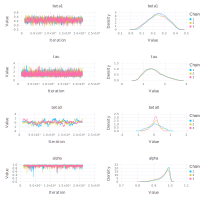

In [15]:
car_p1 = Mamba.plot(car_sim, legend = true);
Mamba.draw(car_p1[:, 1:4], nrow = 4, ncol = 2)

自己相関と、平均の表示

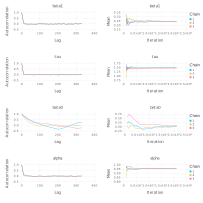

In [16]:
car_p2 = Mamba.plot(car_sim, [:autocor, :mean], legend=true);
Mamba.draw(car_p2[:, 1:4], nrow = 4, ncol = 2)

## 95%信頼区間を求める
シミュレーションされた$\mu$を抽出する

In [17]:
sim_mu = car_sim[:, [:mu], :].value
dim = size(sim_mu)
sim_mu = reshape(sim_mu, dim[1] * dim[3], dim[2])

6000×56 Array{Float64,2}:
  5.33111   8.17028  24.1962   25.8319   …   3.74757  1.21008   1.89642 
 11.3522    6.78098  31.3609   16.059        5.93536  1.85984   1.0309  
  4.62956   8.0547   24.9027   13.7562       5.13148  2.54294   4.24473 
  9.85209   8.91717  19.2611   16.0708       5.20165  2.38677   2.70547 
  8.36303   5.47172  26.6554   24.5478       2.70563  0.744699  1.86499 
 10.0176    6.2623   32.5285   21.1394   …   5.03838  1.27577   2.87073 
  5.11519   5.06373  19.7478   19.945        5.86838  1.41784   3.80153 
  8.13956   9.63394  18.8513   20.1304       1.95675  1.77296   1.26775 
  3.86222   6.0717   21.6019   23.9407       3.59851  2.4123    3.30163 
  5.08827  10.9596   31.0389   21.2224       2.24196  1.70681   2.19546 
  4.51947   7.60043  30.853    17.4662   …   2.99395  1.30943   2.10178 
  4.4241    8.19094  16.7992   15.2971       3.29905  1.84904   3.07697 
  5.81556   9.31445  22.0014   18.2617       2.71342  0.912984  1.7721  
  ⋮                      

各場所が0から100まで値をとる確率を計算する(100超の値をとることもあるが, 確率はかなり小さい)

In [18]:
mu_prob = vcat(map(x -> mean!(ones((1, N)), pdf.(Poisson.(sim_mu), x)), 0:100)...)

101×56 Array{Float64,2}:
 0.00178604   0.00153401   0.0103397    …  0.205548     0.141926   
 0.00812071   0.00721062   0.0351093       0.286633     0.219238   
 0.0200046    0.0184702    0.0646376       0.23049      0.208549   
 0.0354463    0.0342742    0.0861407       0.141497     0.161057   
 0.0506802    0.0516696    0.093593        0.0741599    0.110633   
 0.0622622    0.0673049    0.0885119    …  0.0351671    0.0699659  
 0.0683898    0.0787237    0.0759327       0.0155913    0.0413739  
 0.0690179    0.0848927    0.0607913       0.00658155   0.0231001  
 0.0652468    0.0860433    0.0463858       0.00267013   0.0122702  
 0.0585946    0.0831709    0.0343417       0.00104535   0.00623908 
 0.0504899    0.077517     0.0251401    …  0.00039544   0.00305131 
 0.0420412    0.0702175    0.0186515       0.000144554  0.00144009 
 0.0339971    0.0621497    0.0144964       5.1051e-5    0.000657234
 ⋮                                      ⋱               ⋮          
 7.34538e-8   1.07054e-

強引に和を1にしてしまう

In [19]:
mu_prob = mu_prob ./ mapslices(sum, mu_prob, dims = [1])

101×56 Array{Float64,2}:
 0.00178604   0.00153401   0.0103397    …  0.205548     0.141926   
 0.00812071   0.00721062   0.0351093       0.286633     0.219238   
 0.0200046    0.0184702    0.0646376       0.23049      0.208549   
 0.0354463    0.0342742    0.0861407       0.141497     0.161057   
 0.0506802    0.0516696    0.093593        0.0741599    0.110633   
 0.0622622    0.0673049    0.0885119    …  0.0351671    0.0699659  
 0.0683898    0.0787237    0.0759327       0.0155913    0.0413739  
 0.0690179    0.0848927    0.0607913       0.00658155   0.0231001  
 0.0652468    0.0860433    0.0463858       0.00267013   0.0122702  
 0.0585946    0.0831709    0.0343417       0.00104535   0.00623908 
 0.0504899    0.077517     0.0251401    …  0.00039544   0.00305131 
 0.0420412    0.0702175    0.0186515       0.000144554  0.00144009 
 0.0339971    0.0621497    0.0144964       5.1051e-5    0.000657234
 ⋮                                      ⋱               ⋮          
 7.34538e-8   1.07054e-

quantileを求める

In [20]:
sim_categorical = vec(mapslices(Distributions.Categorical, mu_prob, dims = [1]));
sim_quantile_0025 = quantile.(sim_categorical, 0.025) .- 1
sim_quantile_0500 = quantile.(sim_categorical, 0.500) .- 1
sim_quantile_0975 = quantile.(sim_categorical, 0.975) .- 1

56-element Array{Int64,1}:
 50
 21
 34
 28
 22
 15
 23
 44
 27
 25
 12
 17
 18
  ⋮
 44
 28
 25
 15
 17
 18
 17
 18
 31
 42
  6
  7

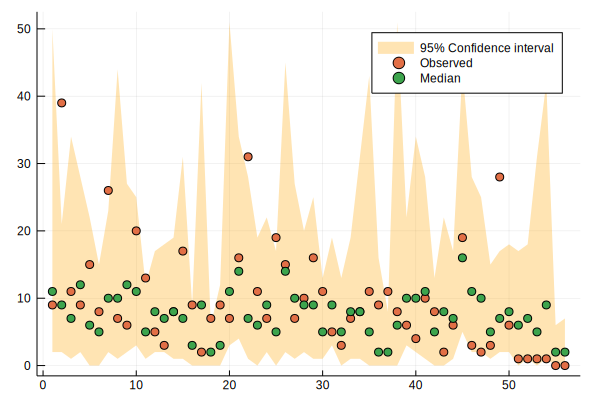

In [21]:
Plots.plot(1:N, sim_quantile_0025, lw = 0, 
    fillrange = sim_quantile_0975,
    fillalpha = 0.3, fillcolor = :orange,
    label = "95% Confidence interval")
scatter!(1:N, observed, label = "Observed")
scatter!(1:N, sim_quantile_0500, label = "Median")